In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import h5py
import os
import sys
sys.path.append('../utils/')
from analysis_fns import normalize_images, display_images

cutouts (10, 5, 64, 64)
dec (10,)
ra (10,)
zspec (10,)


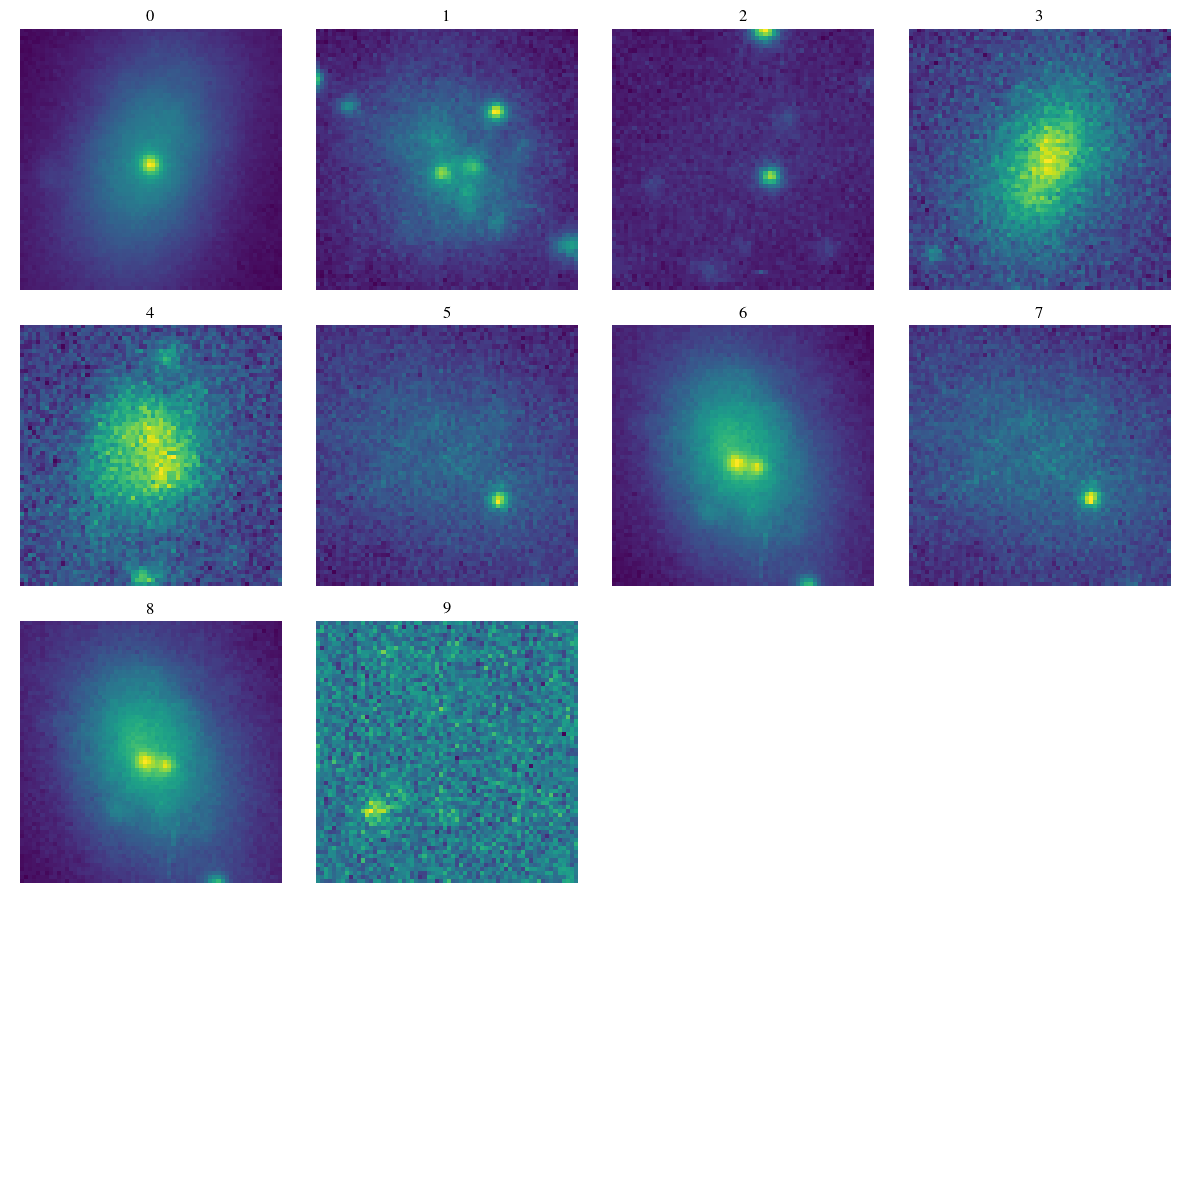

cutouts (51, 5, 64, 64)
dec (51,)
ra (51,)
zspec (51,)


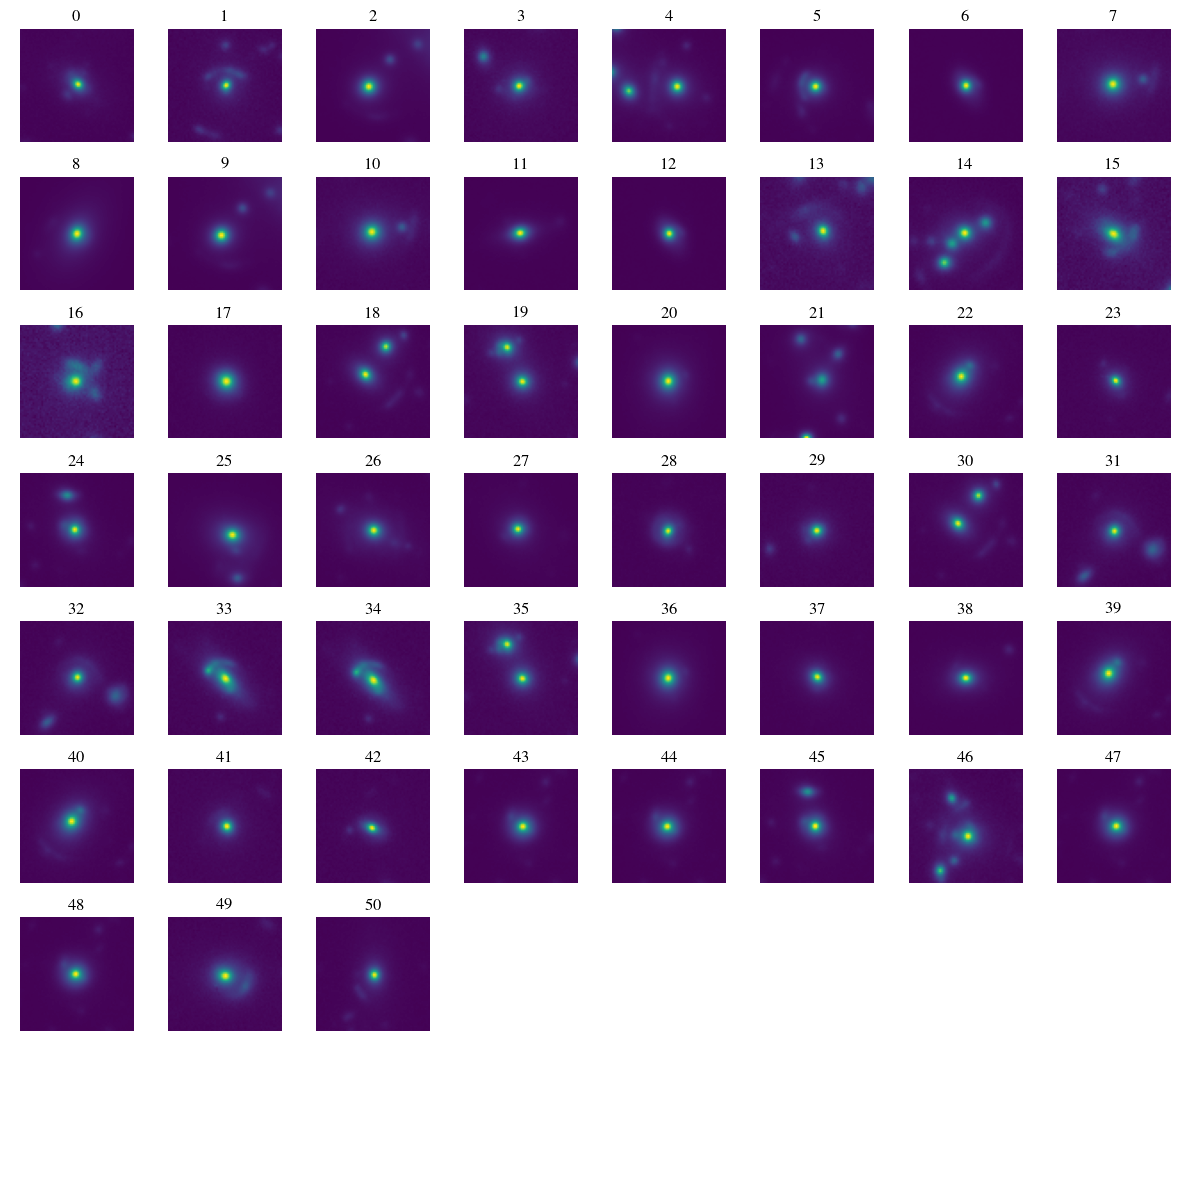

cutouts (79683, 5, 64, 64)
dec (79683,)
ra (79683,)
zspec (79683,)


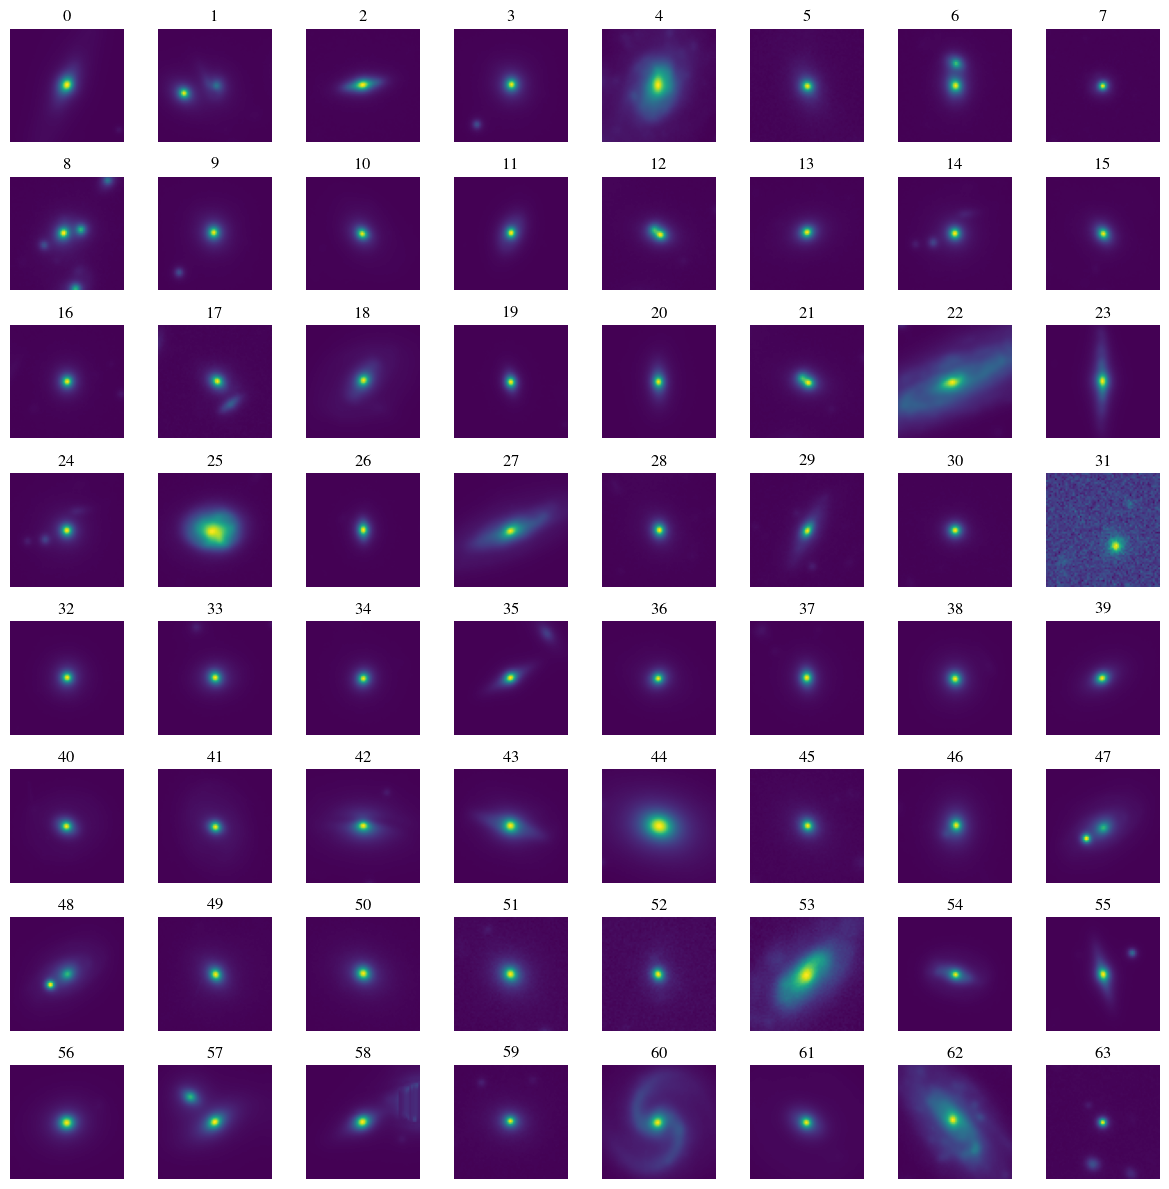

cutouts (13850, 5, 64, 64)
dec (13850,)
ra (13850,)
zspec (13850,)


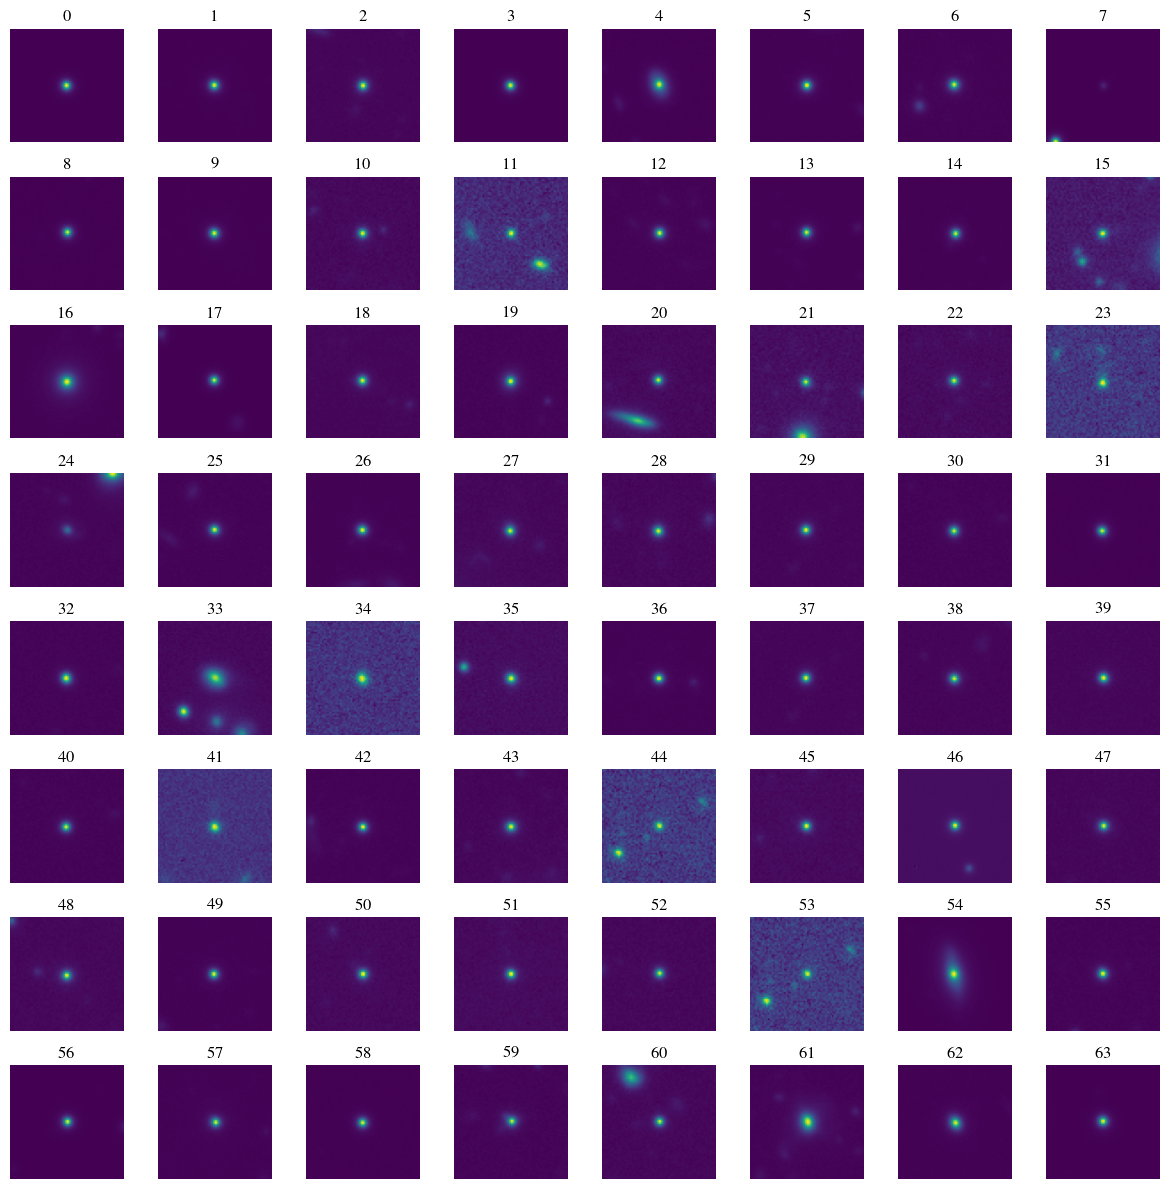

cutouts (36201, 5, 64, 64)
dec (36201,)
ra (36201,)


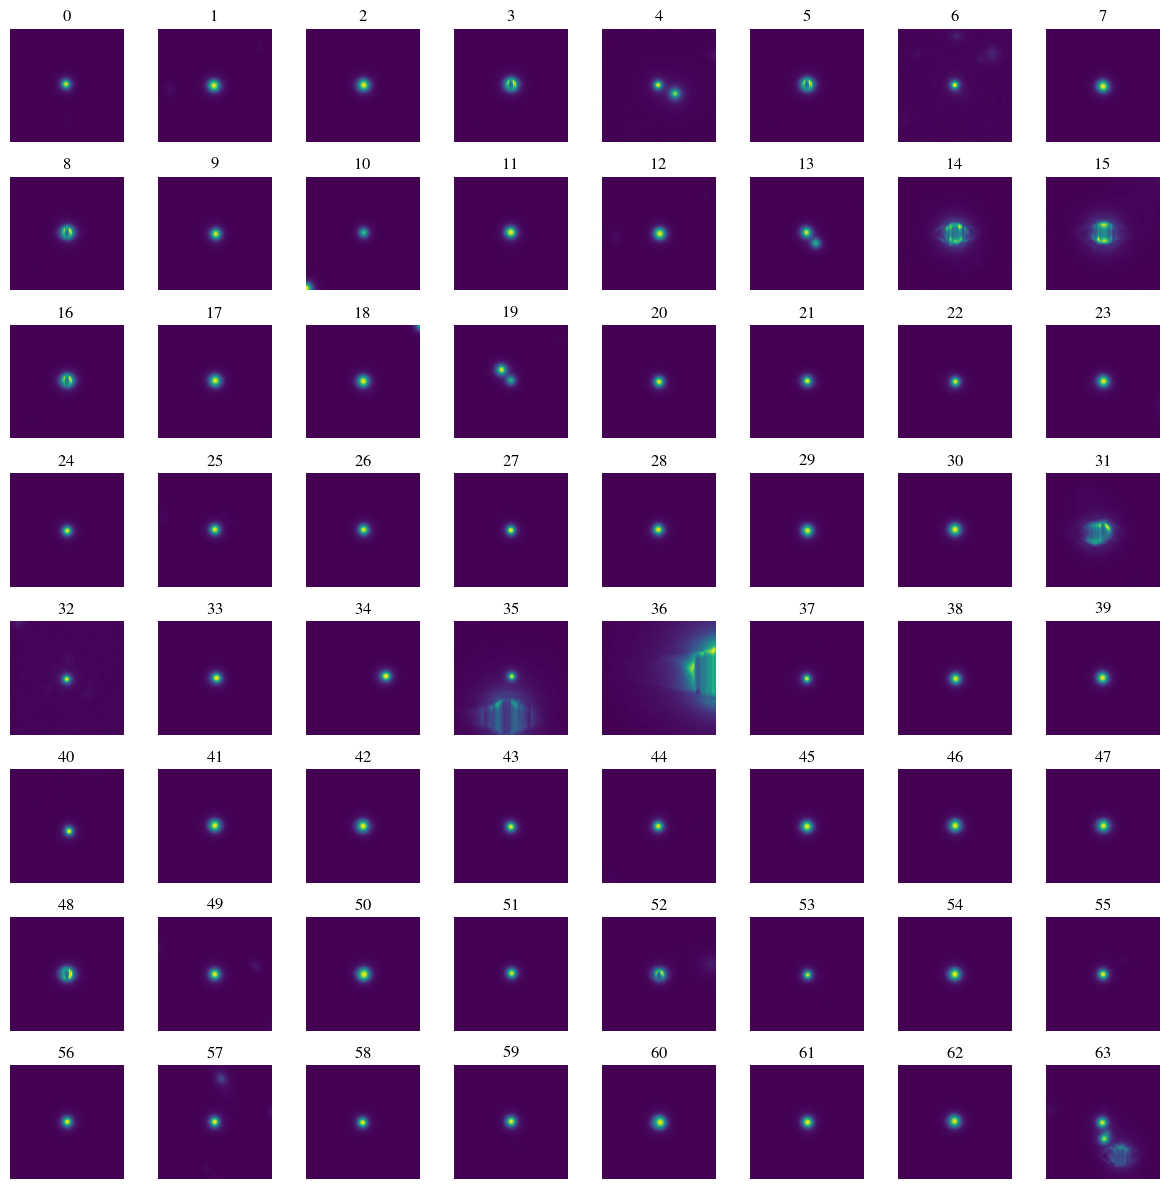

In [89]:
channel = 1
data_dir = '/arc/projects/ots/HSC_h5/'
fns = ['HSC_dwarf_galaxies_GRIZY_64_new.h5',
       'HSC_strong_lens_candidates_GRIZY_64.h5',
       'HSC_galaxies_GRIZY_64_val_new.h5',
       'HSC_qso_GRIZY_64_new.h5',
       'HSC_stars_GRIZY_64_new.h5']

for fn in fns:
    file_path = os.path.join(data_dir, fn)
    with h5py.File(file_path, "r") as f:   
        for k in f.keys():
            print(k, f[k].shape)
            
        cutouts = f['cutouts'][:64]
    
        display_images(normalize_images(cutouts[:,channel]), vmin=0., vmax=1)

In [72]:
n_per_class = 2000
out_filename = 'simple_classifier_data.h5'
classes = [#'dwarf galaxy', 
            'galaxy', 'qso', 'star']
fns = [#'HSC_dwarf_galaxies_GRIZY_64_new.h5',
       'HSC_galaxies_GRIZY_64_val_new.h5',
       'HSC_qso_GRIZY_64_new.h5',
       'HSC_stars_GRIZY_64_new.h5']


out_path = os.path.join(data_dir, out_filename)
with h5py.File(out_path, "w") as f_out:

    cutout_ds = f_out.create_dataset('cutouts', shape=(0,5,64,64), maxshape=(None,5,64,64))
    class_ds = f_out.create_dataset('class', shape=(0,), maxshape=(None,))
    ra_ds = f_out.create_dataset('ra', shape=(0,), maxshape=(None,))
    dec_ds = f_out.create_dataset('dec', shape=(0,), maxshape=(None,))
    dt = h5py.string_dtype(encoding='utf-8')
    name_ds = f_out.create_dataset('class name', shape=(0,), maxshape=(None,), dtype=dt)
        
    for cl_indx, fn in enumerate(fns):
        file_path = os.path.join(data_dir, fn)
        with h5py.File(file_path, "r") as f:   
            cutouts = f['cutouts']
            ras = f['ra']
            decs = f['dec']
            
            # Go through in random order
            indices = np.random.permutation(len(cutouts))
            class_cutouts, class_ra, class_dec = [], [], []
            for i in indices:
                # Only store n_per_class
                if len(class_cutouts)>=n_per_class:
                    break
                
                cutout = cutouts[i]
    
                # Check if bad sample
                if np.any((cutout < -1) | np.isnan(cutout) | (cutout > 200)):
                    continue
    
                # If not, store this one
                class_cutouts.append(cutout)
                class_ra.append(ras[i])
                class_dec.append(decs[i])
    
            class_cutouts = np.array(class_cutouts)
            class_ra = np.array(class_ra)
            class_dec = np.array(class_dec)
        
        # Resize the datasets to accommodate the new data
        num_samples = class_cutouts.shape[0]
        cutout_ds.resize(cutout_ds.shape[0] + num_samples, axis=0)
        class_ds.resize(class_ds.shape[0] + num_samples, axis=0)
        ra_ds.resize(ra_ds.shape[0] + num_samples, axis=0)
        dec_ds.resize(dec_ds.shape[0] + num_samples, axis=0)
        name_ds.resize(name_ds.shape[0] + num_samples, axis=0)
                
        # Add the new data
        cutout_ds[-num_samples:] = class_cutouts
        class_ds[-num_samples:] = np.ones((num_samples,))*cl_indx
        ra_ds[-num_samples:] = class_ra
        dec_ds[-num_samples:] = class_dec
        name_ds[-num_samples:] = np.array([classes[cl_indx]] * num_samples)

class (150,)
class name (150,)
cutouts (150, 5, 64, 64)
dec (150,)
ra (150,)


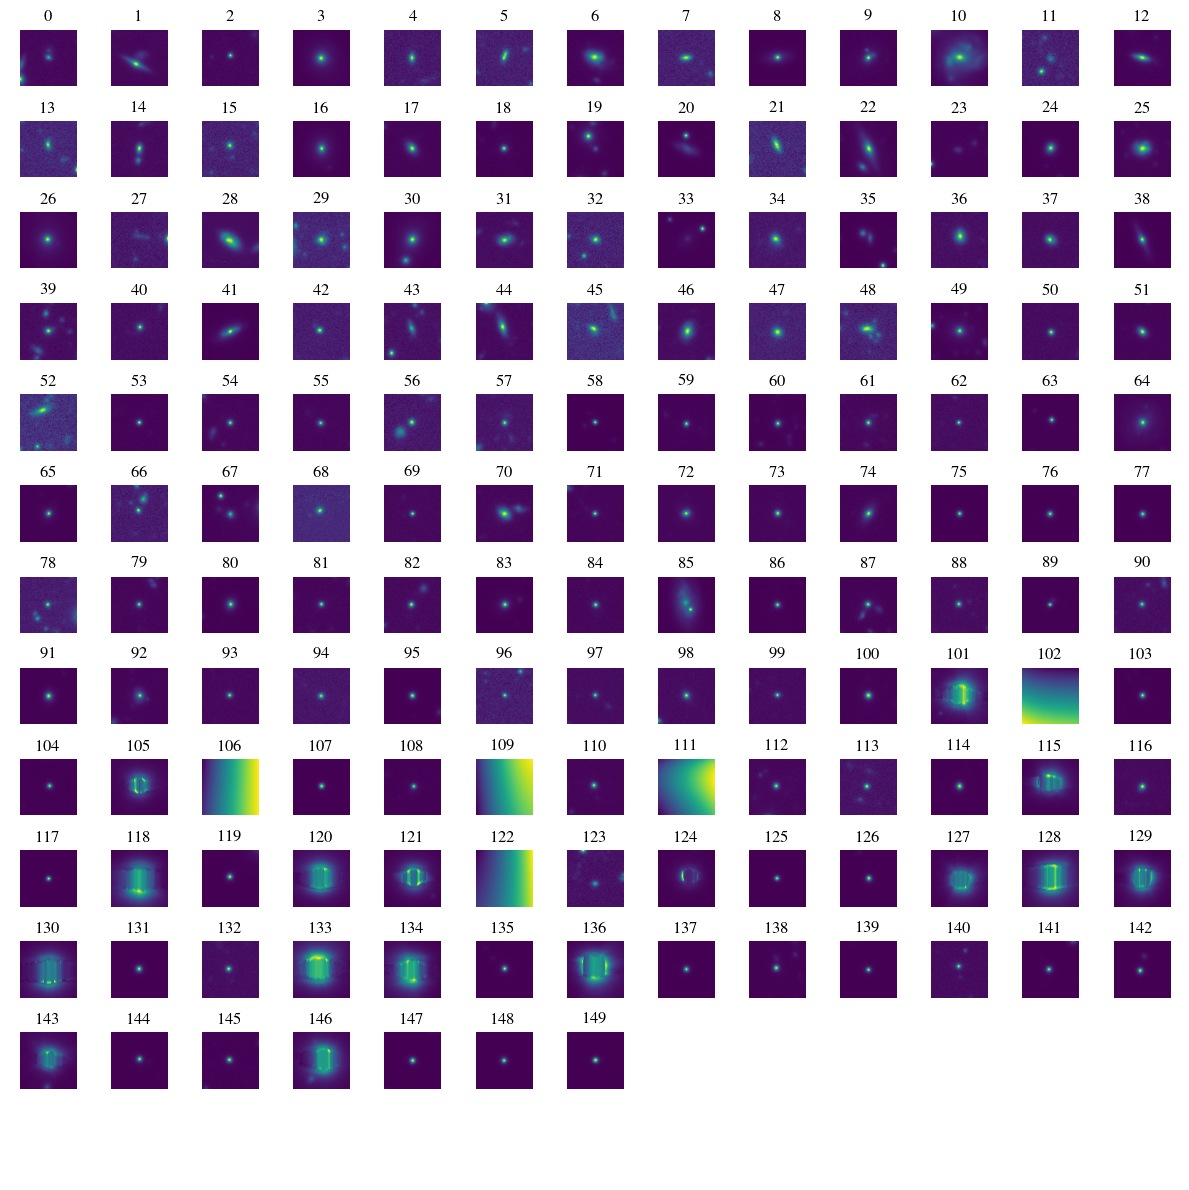

In [69]:
with h5py.File(out_path, "r") as f:
    for k in f.keys():
        print(k, f[k].shape)
            
    cutouts = f['cutouts'][:]

    display_images(normalize_images(cutouts[:,channel]), vmin=0., vmax=1)

In [90]:
fn_out = 'simple_regression_data.h5'
fn_in = 'HSC_galaxies_GRIZY_64_val_new.h5'
num_samples = 6000

with h5py.File(os.path.join(data_dir, fn_out), "w") as f_out:

    cutout_ds = f_out.create_dataset('cutouts', shape=(num_samples,5,64,64))
    zspec_ds = f_out.create_dataset('zspec', shape=(num_samples,))
    ra_ds = f_out.create_dataset('ra', shape=(num_samples,))
    dec_ds = f_out.create_dataset('dec', shape=(num_samples,))

    with h5py.File(os.path.join(data_dir, fn_in), "r") as f:   
    
        zspec = f['zspec'][:]

        # Go through in random order
        indices = np.random.permutation(np.where((zspec>0.2)&(zspec<1.0))[0])

        i_out = 0
        for i_in in indices:
            if i_out>=num_samples:
                break

            cutout = f['cutouts'][i_in]
    
            # Check if bad sample
            if np.any((cutout < -1) | np.isnan(cutout) | (cutout > 200)):
                continue
       
            # Add the new data
            cutout_ds[i_out] = cutout
            zspec_ds[i_out] = f['zspec'][i_in]
            ra_ds[i_out] = f['ra'][i_in]
            dec_ds[i_out] = f['dec'][i_in]
            i_out+=1

cutouts (4000, 5, 64, 64)
dec (4000,)
[ 5.5816677e+01 -5.9353342e+00 -4.5443773e+00  1.9282259e-01
  1.6070421e-01  5.8915883e-01  3.2431868e-01  2.7835393e+00
  1.5040947e+00 -4.4473910e+00  2.4262216e+00  4.0375400e-02
 -4.4576535e+00 -3.1459220e-02  5.4023811e+01 -4.4357119e+00
  2.2085016e+00  5.5127171e+01 -4.5790873e+00 -1.5592368e+00
  5.3316422e+01 -4.5184913e+00 -7.4203886e-02 -4.3723383e+00
  5.4746380e+01  5.4226967e+01 -2.7157778e-02  1.0743290e+00
 -1.2219854e-02  5.3585468e+01  9.7266519e-01 -1.6790833e-02
  5.3540859e+01  1.4398372e+00 -9.6913250e-03 -4.9268198e+00
 -4.5750275e+00  1.5123600e+00  1.5547712e+00  8.3744697e-02
  1.5285499e-01 -7.6913249e-01  1.7053061e+00  2.1661091e+00
  8.9774936e-02  2.8519693e-01 -3.2814799e-03  8.6781508e-01
  8.3627540e-01 -4.5482769e+00 -2.8979981e-01  2.6933801e-01
  4.6292789e-02  6.1099149e-02  2.4662728e+00  2.4719446e-03
  2.6012889e-01 -1.2077890e-02  2.5733669e+00  2.5105277e-01
  5.3639084e+01  1.2674830e-02 -4.6221557e+00  

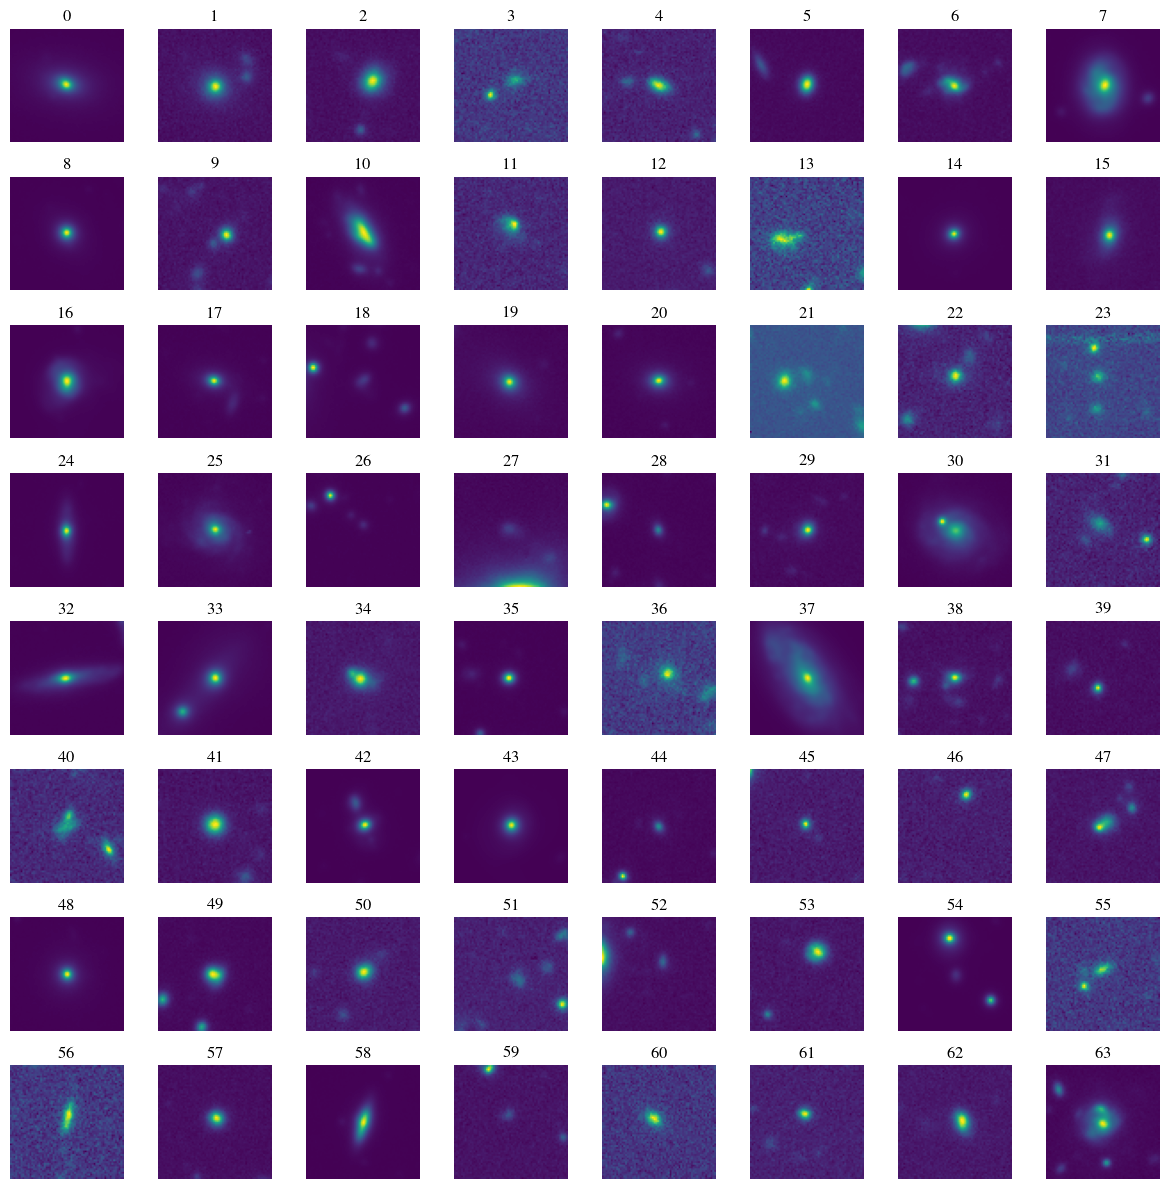

In [87]:
channel = 1

with h5py.File(os.path.join(data_dir, fn_out), "r") as f:   
    for k in f.keys():
        print(k, f[k].shape)
        if 'cutout' in k:
            continue
        else:
            print(f[k][-64:])
        
    cutouts = f['cutouts'][-64:]
    display_images(normalize_images(cutouts[:,channel]), vmin=0., vmax=1)

In [ ]:
np.any((cutout < -1) | np.isnan(cutout) | (cutout > 200))